# Домашнее задание №1

## Задача 1

1. Покажите, что градиенты, полученные на двух последовательных шагах градиентного спуска с использованием правила наискорейшего спуска, ортогональны.

По условию наискорейшего спуска, для шага $x^{k+1} = x^{k} - \alpha f'(x^k)$ число $\alpha$ подбирается как $argmin_{\alpha}f(x^{k+1})$ при всех $\alpha \in [0, +\infty)$. Условие на минимум дает $0 = \frac{\delta f}{\delta\alpha} = <\frac{\delta f}{\delta x^{k+1}}, \frac{\delta x^{k+1}}{\delta\alpha}> = <f'(x^{k+1}), -f'(x^{k}) > $, что эквивалетно перпендикулярности векторов $f'(x^{k+1}), f'(x^{k})$


2. Покажите, что для $f(x) = x^Tx$ градиентный спуск с выбором шага по правилу наискорейшего спуска сходится за одну итерацию.

Для первого шага имеем: $x^1 = x^0 - \alpha f'(x^0) = (1 - 2\alpha) x^0$. Подбираем $\lambda$ как $argmin_{\alpha}{x^1}^Tx^1 = argmin_{\alpha}(1 - 2\alpha)^2{x^0}^Tx^0 = \frac{1}{2}$. 
Указанный $\alpha$ дает минимальное значение $f(x)$ при любых $x^0$ 

## Задача 2

1. Реализуйте градиентный спуск, шаг метода $\alpha$ необходимо выбирать по правилу Армихо.

2. Задайте три квадратичные функции $(n = 2,\ 10,\ 1000)$ с разными числами обусловленности $(𝟆 = 1,\ 100,\ 10000)$. Всего у вас получается 9 разных матриц A. Запустите на них методы следующим образом:
- рассмотрите разные начальные точки(не менее 2ух);
- рассмотрите разную точность для остановки(не менее 3ех);

Постарайтесь ответить на вопрос: как зависит поведение методов от числа обусловленности и от начальной точки?

**Замечание 1. Критерий остановки** В этом задании используйте следующий критерий остановки:
$$\frac{\left\|∇f(x_k)\right\|_2^2}{\left\|∇f(x_0)\right\|_2^2} \le ɛ$$

Этот критерий задает относительную точность решения благодаря нормировке на $\left\|∇f(x_0)\right\|_2^2$.

**Замечание 2. Квадратичная функция** Рассмотрим матрицу $A \in \mathbf{S}^n_{++}$ и вектор $b \in \mathbf{R}^n$ и зададим функцию
$$f(x) = \frac{1}{2} x^TAx + b^Tx$$.

Её число обусловленности зависит от матрицы $A$ и равняется $𝟆 = \frac{\lambda_{max}}{\lambda_{min}} = \frac{L}{μ}$, где 𝐿 – константа Липшица градиента, а 𝜇 - константа сильной выпуклости. В задании вам необходимо исследовать поведение метода в зависимости от числа обусловленности.

Сгенерировать случайную квадратичную задачу с заданным $𝟆$ можно, например, так: взять случайные числа $\lambda_1, \lambda_2, \dots \lambda_n \in [1, 𝟆]$, так что $min_i\lambda_i = 1$, а $max_i\lambda_i = 𝟆$, и положить $A = diag(\lambda_1, \dots \lambda_n)$. Элементы вектора $b$ можно взять произвольными, они на обусловленность не влияют.

In [ ]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def ArmijoStep(x, h, gradf, f, beta, rho, alpha0):
  fx = f(x)
  hg = h.dot(gradf(x))
  alpha = alpha0
  while f(x + alpha * h) > fx + beta * alpha * hg:
    alpha *= rho
  return alpha

In [ ]:
def GradientDescentArmijo(x0, f, gradf, tol=1e-3, max_iter=10000, beta=0.3, rho=0.1, alpha0=1):
  history = [(x0, time.time())]
  x = x0.copy()
  gradf0 = np.linalg.norm(gradf(x0))
  k = 0
  x_prev = None
  while x_prev is None or (np.linalg.norm(gradf(x)) ** 2 / gradf0 ** 2) > tol: 
    h = -gradf(x)
    alpha = ArmijoStep(x, h, gradf, f, beta, rho, alpha0)
    x_prev, x = x, x + alpha * h
    history.append((x, time.time()))
    if k >= max_iter:
      break
    k += 1
  return x, history

In [ ]:
def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind]-times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values

Построим для каждого $n$ график с зависимостями относительной нормы градиента от времени работы и от номера итерации для разных чисел обусловленности. Начальную точку возьмем $x_0 = 0$

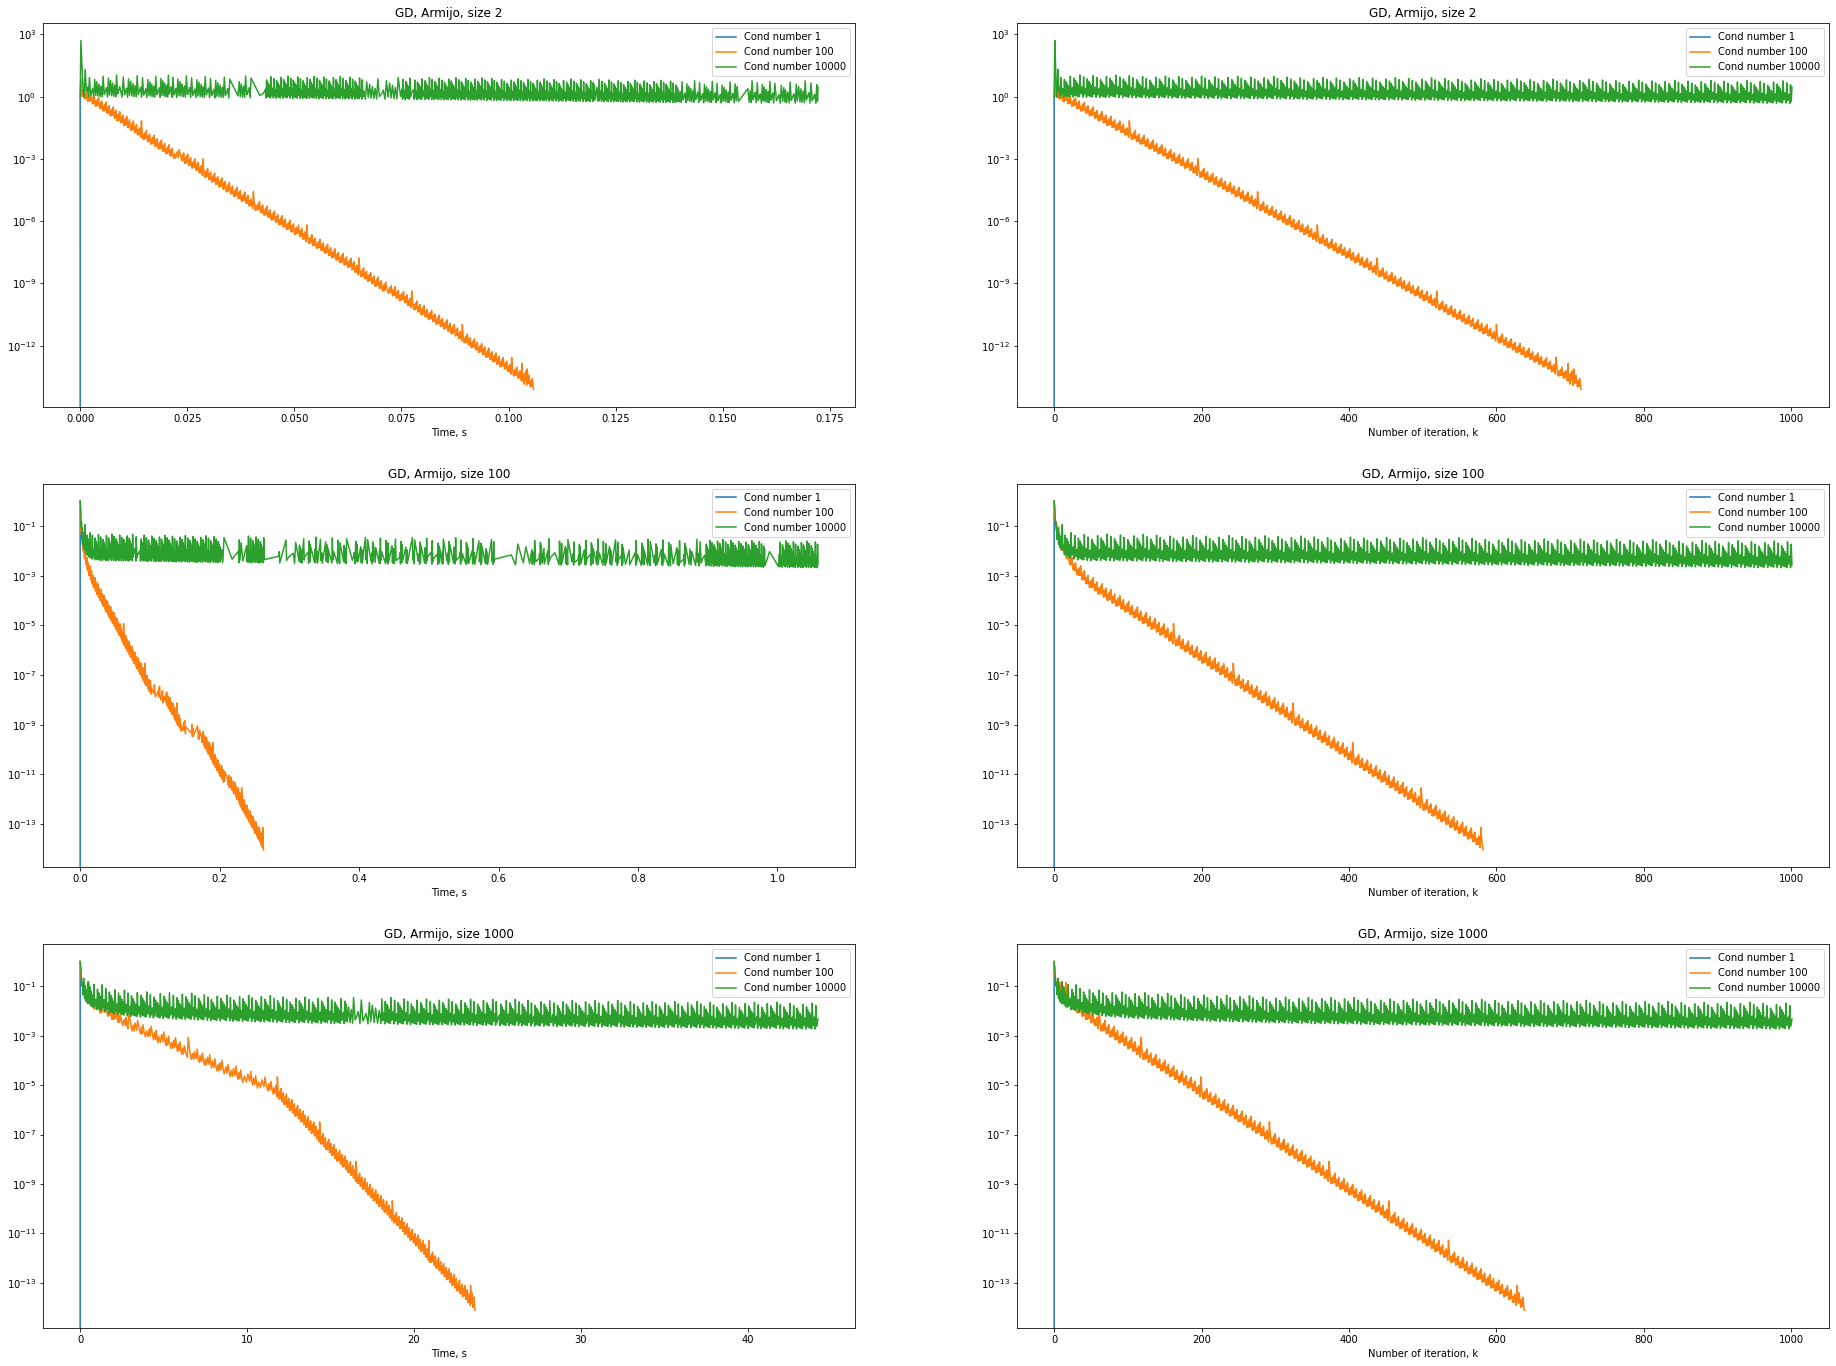

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(32, 24))
n_sizes = [2, 100, 1000]
histories = {}
A_list = {}
b_list = {}

for i, axis in enumerate(axes.flat):
  n = n_sizes[int(i / 2)]
  ret_time = (i % 2 == 0)
  axis.set_title(f"GD, Armijo, size {n}")
  axis.set_xlabel("Time, s" if ret_time else "Number of iteration, k")
  for k in [1, 100, 10000]:
    if ret_time:
      lambdas = np.random.default_rng().integers(low=1, high=k+1, size=n)
      lambdas[0] = 1
      lambdas[-1] = k
      A = np.diag(lambdas)
      b = np.random.randn(n)
      x0 = np.zeros(n)

      f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
      gradf = lambda x: A @ x + b

      x_min, xhistory = GradientDescentArmijo(x0, f, gradf, tol=1e-14, max_iter=1000, rho=1/2)
      histories[k] = xhistory
      A_list[k] = A
      b_list[k] = b
    else:
      xhistory = histories[k]
      A = A_list[k]
      b = b_list[k]
      f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
      gradf = lambda x: A @ x + b
    funcx = lambda x: (np.linalg.norm(gradf(x)) ** 2) / (np.linalg.norm(gradf(np.zeros(n))) ** 2)
    times, values = parse_logs(xhistory, ret_time=ret_time, funcx=funcx)
    axis.semilogy(times, values, label=f"Cond number {k}")
  axis.legend()


Возьмем начальную точку $x_0 ≃ -A^{-1}b$

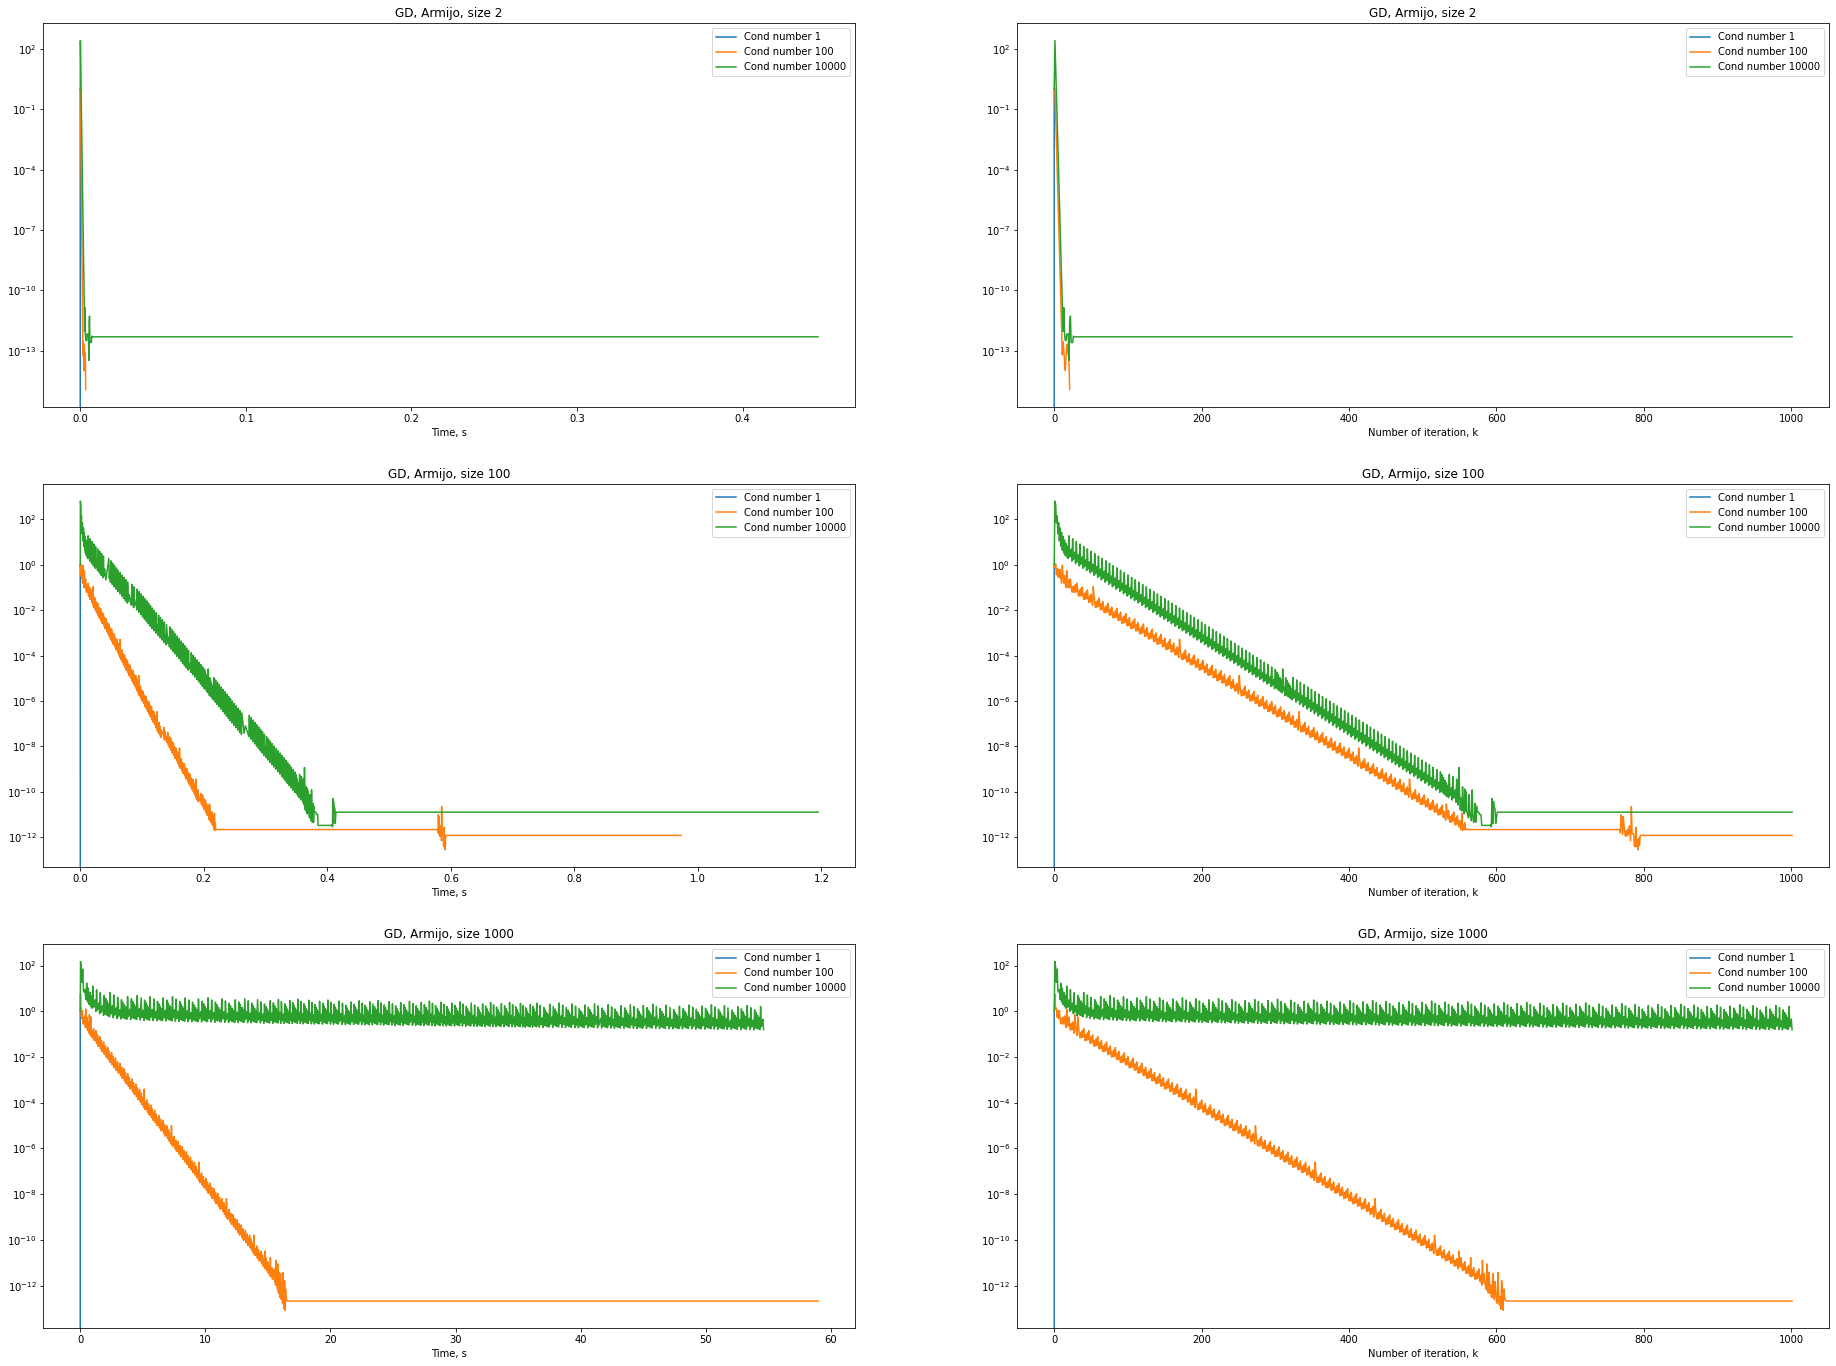

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(32, 24))
n_sizes = [2, 100, 1000]
histories = {}
A_list = {}
b_list = {}
x0_list = {}

for i, axis in enumerate(axes.flat):
  n = n_sizes[int(i / 2)]
  ret_time = (i % 2 == 0)
  axis.set_title(f"GD, Armijo, size {n}")
  axis.set_xlabel("Time, s" if ret_time else "Number of iteration, k")
  for k in [1, 100, 10000]:
    if ret_time:
      lambdas = np.random.default_rng().integers(low=1, high=k+1, size=n)
      lambdas[0] = 1
      lambdas[-1] = k
      A = np.diag(lambdas)
      b = np.random.randn(n)
      x0 = - np.linalg.inv(A + 0.3 * np.eye(n)) @ b

      f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
      gradf = lambda x: A @ x + b
      funcx = lambda x: (np.linalg.norm(gradf(x)) ** 2) / (np.linalg.norm(gradf(x0)) ** 2)

      x_min, xhistory = GradientDescentArmijo(x0, f, gradf, tol=1e-14, max_iter=1000, rho=1/2)
      histories[k] = xhistory
      A_list[k] = A
      b_list[k] = b
      x0_list[k] = x0
    else:
      xhistory = histories[k]
      A = A_list[k]
      b = b_list[k]
      x0 = x0_list[k]
      f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
      gradf = lambda x: A @ x + b
      funcx = lambda x: (np.linalg.norm(gradf(x)) ** 2) / (np.linalg.norm(gradf(x0)) ** 2)
    times, values = parse_logs(xhistory, ret_time=ret_time, funcx=funcx)
    axis.semilogy(times, values, label=f"Cond number {k}")
  axis.legend()
